In [1]:
import pandas as pd
import gc
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

import warnings
from itertools import combinations
from warnings import simplefilter

import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
# logger
import logging
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
# 忽略警告
import warnings
warnings.filterwarnings('ignore')
# save model
import pickle
from sklearn.model_selection import train_test_split, cross_val_score

sns.set_style('whitegrid')
sns.set_palette('Set2')

TRANING = True

In [2]:
if TRANING:
    df = pd.read_csv('data/train.csv')

In [4]:
df[df['stock_id']==0]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236980,0,480,500,0.00,0,0.999017,42161928.97,0.999017,0.999017,0.999017,53827.20,0.999193,146071.08,0.999065,3.999472,26450,480_500_0
5237180,0,480,510,0.00,0,0.998842,42161928.97,0.998842,0.998842,0.998842,157865.40,0.999017,120926.08,0.998941,3.190041,26451,480_510_0
5237380,0,480,520,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,57596.67,0.999368,46780.58,0.999289,-0.169873,26452,480_520_0
5237580,0,480,530,475513.69,-1,0.999193,41686415.27,0.999017,0.999017,0.999193,156610.53,0.999368,122677.94,0.999291,3.110170,26453,480_530_0


In [39]:
def reduce_mem_usage(df, verbose=0):

    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    return df

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">1.数据预处理</span></h1>
</div>

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">1.1 缺失值观察</span></h2>
</div>

In [40]:
if TRANING:
    print(df.isnull().sum()/df.shape[0])

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000042
imbalance_buy_sell_flag    0.000000
reference_price            0.000042
matched_size               0.000042
far_price                  0.552568
near_price                 0.545474
bid_price                  0.000042
bid_size                   0.000000
ask_price                  0.000042
ask_size                   0.000000
wap                        0.000042
target                     0.000017
time_id                    0.000000
row_id                     0.000000
dtype: float64


其中`row_id`: (data_id)\_(seconds_in_bucket)\_(stock_id)

并且观察缺失值比例，发现far_price 和 near_price 缺失值比例较大，但是这和拍卖机制有关，在后面加入分类变量`after55`来协助模型就好

其中matched_size，imbalance_buy_sell_flag，imbalance_size，reference_price 是闭市拍卖中在3:50到3:55的会给出的，3:55同时结束MOC，之后会给出near_price和far_price，然后在3:58停止LOC，IO在4:00结束。具体见下图所示，本问题的好处在于前四个指标都给出了，同时还给了其他的指标用于提高模型的准确性。这同时意味着需要我们对于特征工程的处理要更加细致。

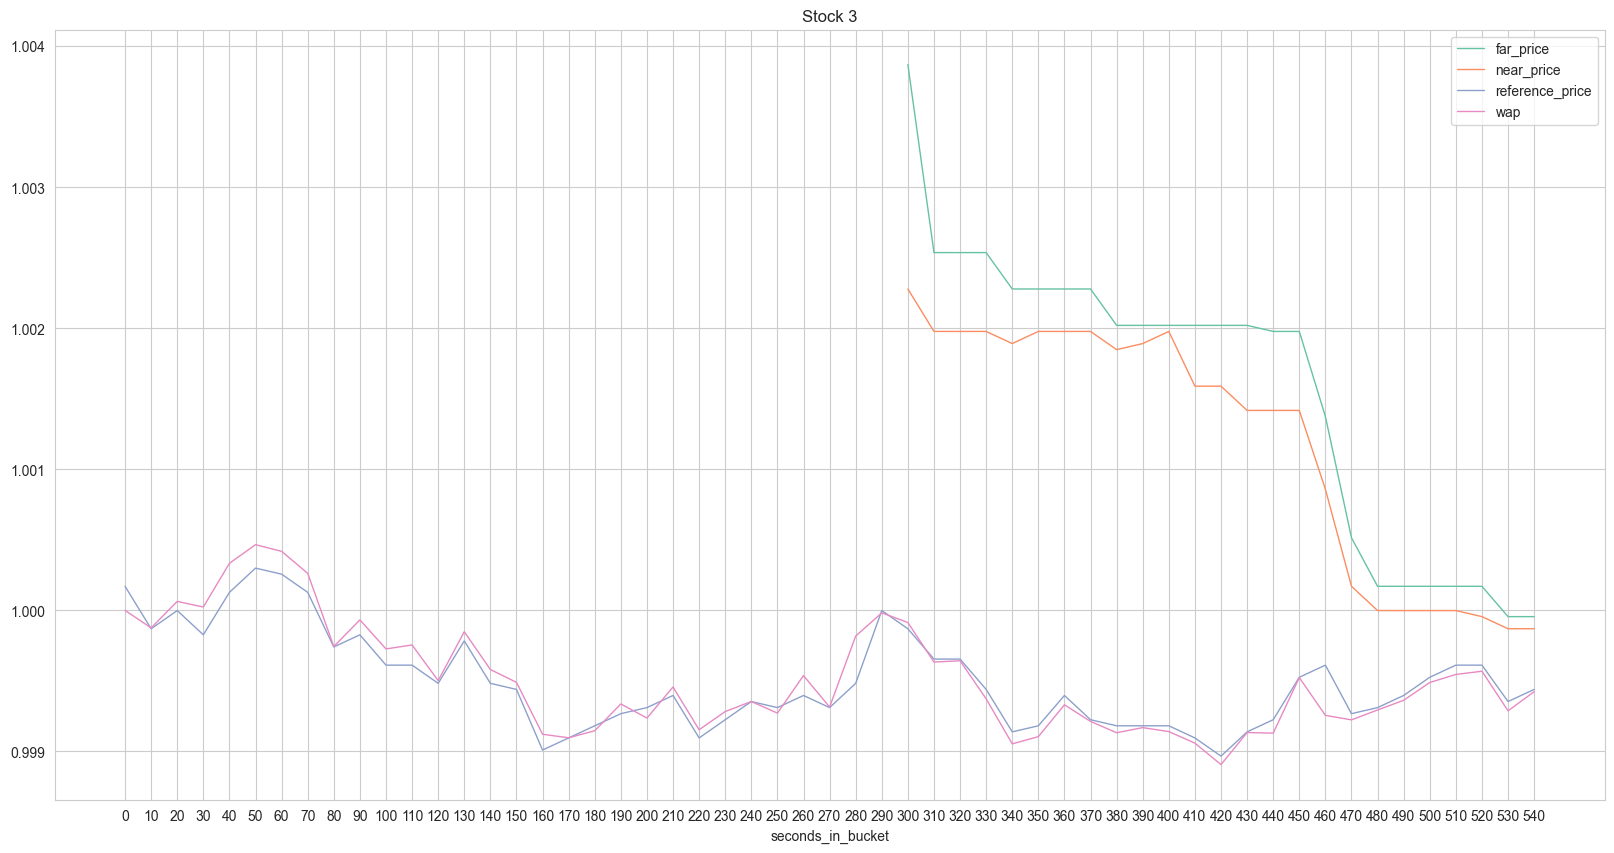

In [41]:
if TRANING:
    stock_id = 3

    df.query(f'stock_id == {stock_id} & date_id ==0')[['seconds_in_bucket','far_price','near_price','reference_price','wap']].set_index(
        'seconds_in_bucket').plot(
            title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, 550, 10))

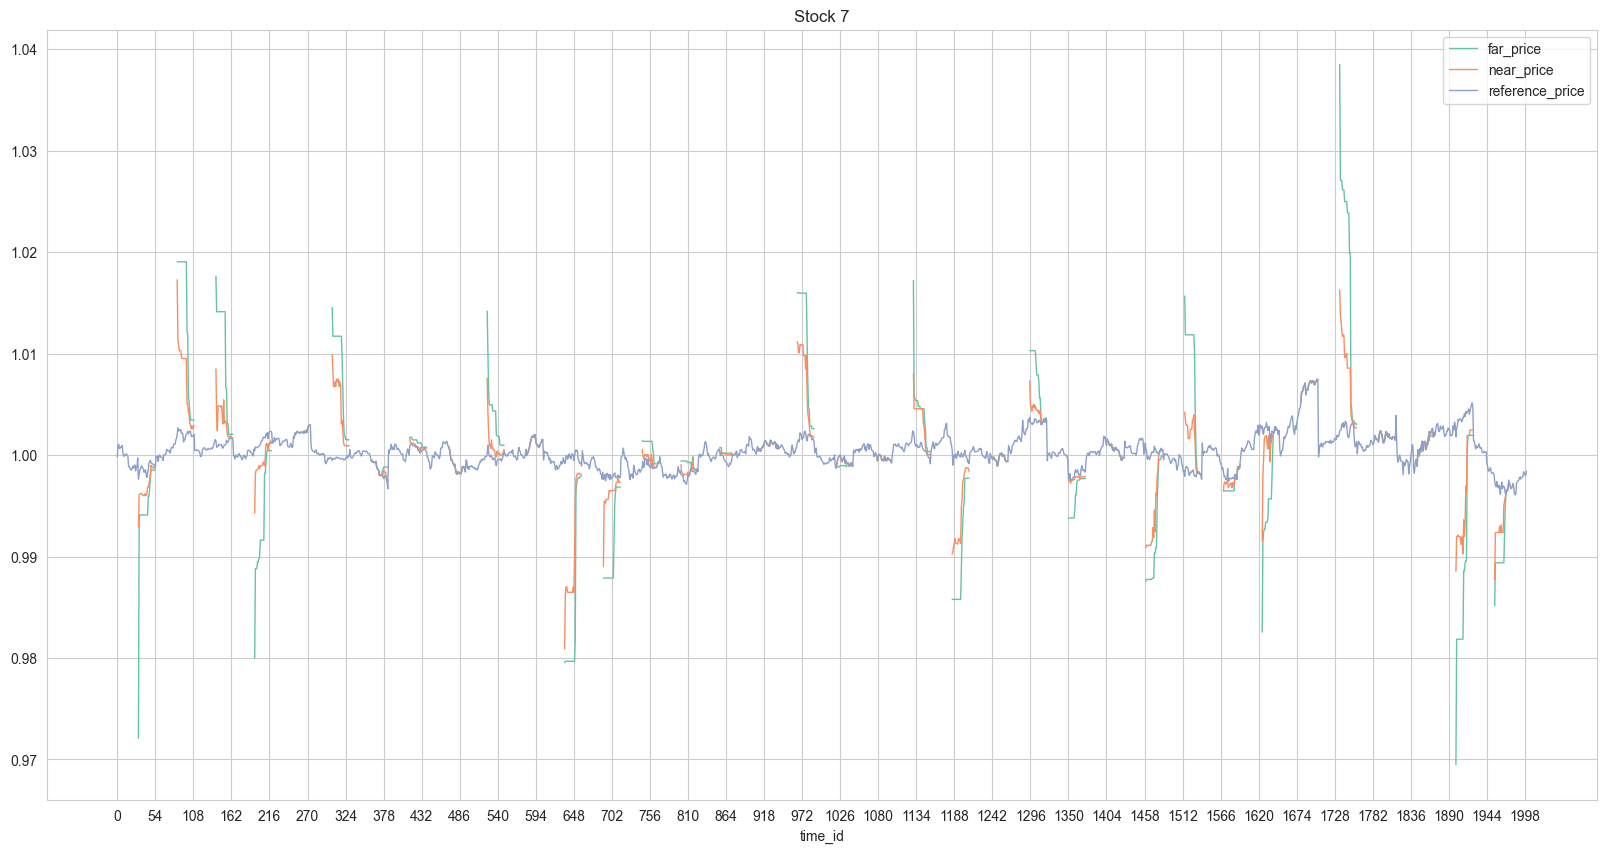

In [42]:
if TRANING:
    stock_id = 7
    time_long = 2000
    df.query(f'stock_id == {stock_id} & time_id <={time_long}')[['time_id','far_price','near_price','reference_price']].set_index(
        'time_id').plot(
            title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, time_long+1, 54))

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">1.2 缺失值处理</span></h2>
</div>

- 对于target缺失的，暂时删去stock
- 对于其他数据缺失的，对于相同stock_id，相同date_id的，数据类似于[nan,nan,nan,10,9,8],则用[10,10,10,10,9,8]填充，如果是[nan,nan,nan,nan,nan,nan]，则用[0,0,0,0,0,0]填充

## 处理target缺失值

In [43]:
if TRANING:
    print(np.sort(df[(df['target'].isnull())]['stock_id'].unique()).tolist())

[19, 101, 131, 158]


In [44]:
if TRANING:
    print(df.isnull().sum()/df.shape[0])

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000042
imbalance_buy_sell_flag    0.000000
reference_price            0.000042
matched_size               0.000042
far_price                  0.552568
near_price                 0.545474
bid_price                  0.000042
bid_size                   0.000000
ask_price                  0.000042
ask_size                   0.000000
wap                        0.000042
target                     0.000017
time_id                    0.000000
row_id                     0.000000
dtype: float64


In [45]:
if TRANING:
    # 对于target为nan的数据，丢弃
    df = df[~df['stock_id'].isin(np.sort(df[(df['target'].isnull())]['stock_id'].unique()).tolist())] 


In [46]:
if TRANING:
   print(df.isnull().sum()/df.shape[0])

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000000
imbalance_buy_sell_flag    0.000000
reference_price            0.000000
matched_size               0.000000
far_price                  0.552467
near_price                 0.545455
bid_price                  0.000000
bid_size                   0.000000
ask_price                  0.000000
ask_size                   0.000000
wap                        0.000000
target                     0.000000
time_id                    0.000000
row_id                     0.000000
dtype: float64


说明target为nan的确实是有问题的数据, 但是nearprice和farprice依旧是缺失值，并且几乎是50%，这是由于特殊的机制导致的。

## 处理其他缺失值

In [47]:
if TRANING:
    # 向前填充
    # 对于 'far_price' 列进行处理，确保索引对齐
    df['far_price'] = df.groupby(['stock_id', 'date_id'])['far_price'].apply(lambda x: x.bfill().fillna(0)).reset_index(level=[0,1], drop=True)

    # 对于 'near_price' 列进行处理，确保索引对齐
    df['near_price'] = df.groupby(['stock_id', 'date_id'])['near_price'].apply(lambda x: x.bfill().fillna(0)).reset_index(level=[0,1], drop=True)

In [50]:
if TRANING:
    df.isnull().sum()/df.shape[0]

## 现在没有缺失值了，画图效果如下

In [52]:
if ~TRANING:
    df = pd.read_csv('data/train_cleaned.csv')

<Axes: title={'center': 'Stock 7'}, xlabel='time_id'>

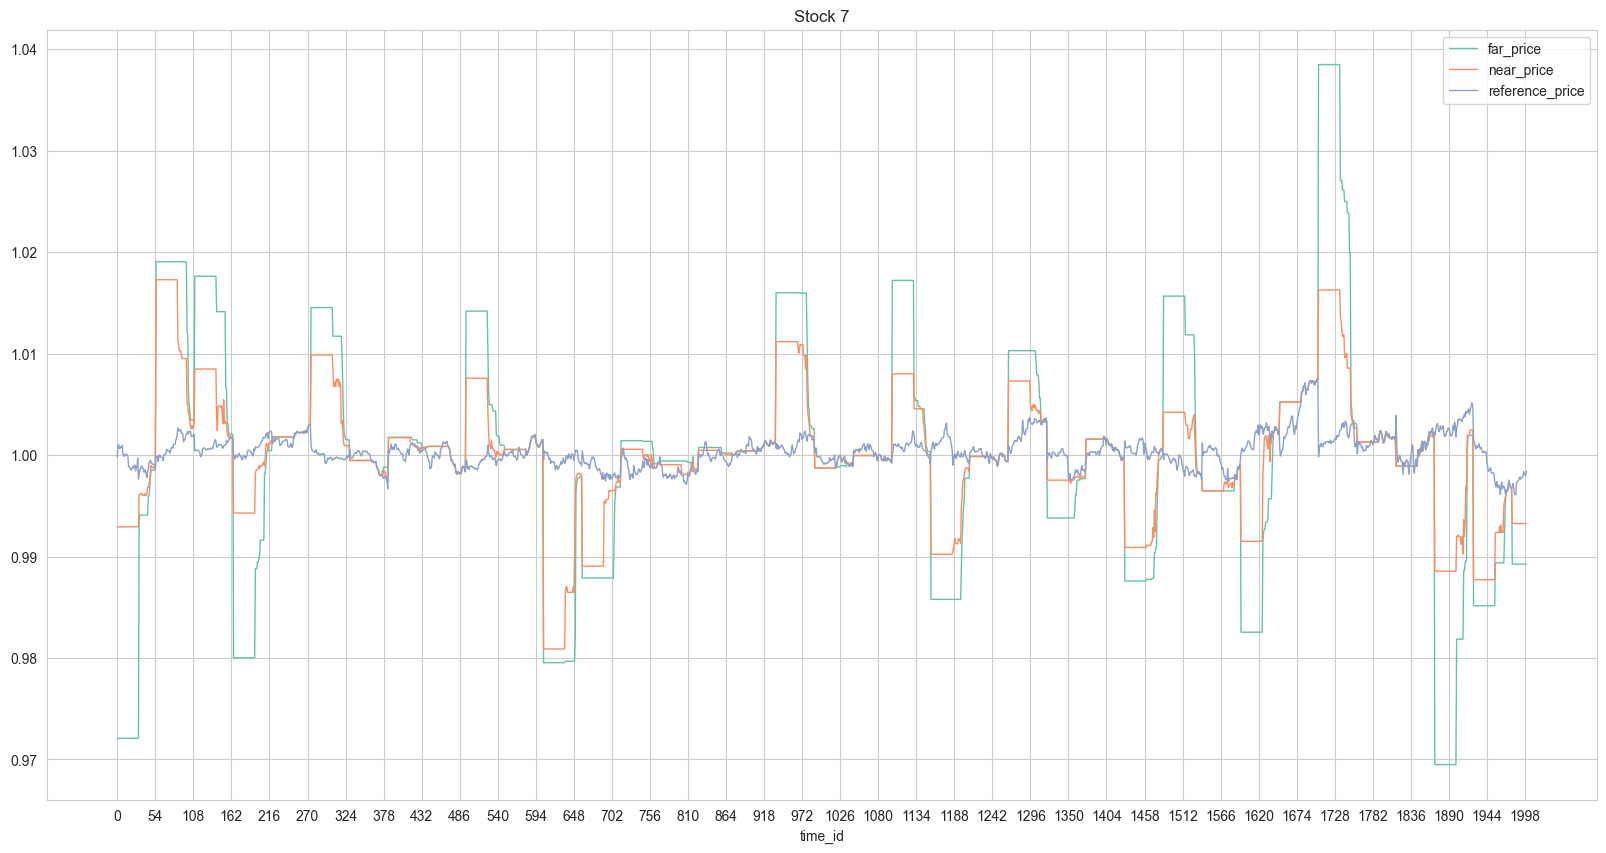

In [53]:
stock_id = 7
time_long = 2000
df.query(f'stock_id == {stock_id} & time_id <={time_long}')[['time_id','far_price','near_price','reference_price']].set_index(
    'time_id').plot(
        title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, time_long+1, 54))

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">2. 特征工程</span></h1>
</div>

## 生成特征

In [55]:
def imbalance_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values

    df["weighted_wap"] = df["stock_weights"] * df["wap"]
    df['wap_momentum'] = df.groupby('stock_id')['weighted_wap'].pct_change(periods=6)
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    df['spread_depth_ratio'] = (df['ask_price'] - df['bid_price']) / (df['bid_size'] + df['ask_size'])
    df['mid_price_movement'] = df['mid_price'].diff(periods=5).apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['micro_price'] = ((df['bid_price'] * df['ask_size']) + (df['ask_price'] * df['bid_size'])) / (df['bid_size'] + df['ask_size'])
    df['relative_spread'] = (df['ask_price'] - df['bid_price']) / df['wap']
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)
            
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size',
                'wap', 'near_price', 'far_price']:
        for window in [1, 2, 3, 5, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)
    
    df['after55'] = df['seconds_in_bucket'].apply(lambda x: 1 if x > 290 else 0)

    return df

# generate all features
def generate_all_features(df):
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    df = imbalance_features(df)
    gc.collect()
    
    feature_name = [i for i in df.columns if i not in ["row_id", "time_id", "date_id"]]
    
    return df[feature_name]

In [ ]:
# def generate_features(df):
#     # Checking for required columns
#     features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 
#                         'matched_size', 'bid_size', 'ask_size', 'reference_price', 
#                         'far_price', 'near_price', 'ask_price', 'bid_price', 'wap', 
#                         'target','after55','imb','imb_s1','imb_s2']
    

#     # Directly creating new columns
#     df['imb'] = df['imbalance_buy_sell_flag'] * df['imbalance_size']
#     df['imb_s1'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'])
#     df['imb_s2'] = (df['imbalance_size'] - df['matched_size']) / (df['matched_size'] + df['imbalance_size'])
#     df['after55'] = df['seconds_in_bucket'].apply(lambda x: 1 if x > 290 else 0)

#     prices = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']


#     for i, a in enumerate(prices):
#         for j, b in enumerate(prices):
#             if i > j:
#                 df[f'{a}_{b}_imb'] = (df[a] - df[b]) / (df[a] + df[b])
#                 df[f'{a}_{b}_imb2'] = (df[a] * df[b]) / (df[a] + df[b])
#                 features.extend([f'{a}_{b}_imb', f'{a}_{b}_imb2'])


#     for i, a in enumerate(prices):
#         for j, b in enumerate(prices):
#             for k, c in enumerate(prices):
#                 if i > j and j > k:
#                     max_ = df[[a, b, c]].max(axis=1)
#                     min_ = df[[a, b, c]].min(axis=1)
#                     mid_ = df[[a, b, c]].sum(axis=1) - min_ - max_
#                     df[f'{a}_{b}_{c}_imb'] = (max_ - mid_) / (mid_ - min_)
#                     df[f'{a}_{b}_{c}_imb2'] = (max_ - min_) / (mid_ + min_)
#                     features.extend([f'{a}_{b}_{c}_imb', f'{a}_{b}_{c}_imb2'])

#     # Final print statement for debugging
#     print("size", df.shape)

#     return df[features]




: 

In [ ]:
TRAIN = True
if TRAIN:
    df_gen = generate_all_features(df)

In [ ]:
df_gen.isin([np.inf, -np.inf]).sum()

In [ ]:
def drop_columns_with_infinite(df, threshold=500):
    infinite_count = df.isin([np.inf, -np.inf]).sum()
    columns_to_drop = infinite_count[infinite_count > threshold].index
    return df.drop(columns=columns_to_drop)

df_gened = drop_columns_with_infinite(df_gen)

: 

In [ ]:
target = df_gened['target']
features = df_gened.drop(columns=['target'])

: 

In [ ]:

if TRANING:
    # 按照数据顺序划分训练集和验证集
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 使用XGBoost训练模型
    model = xgb.XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, random_state=2023, early_stopping_rounds=50,objective='reg:squarederror')
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)

    # 评估模型 mae
    from sklearn.metrics import mean_absolute_error
    mean_absolute_error(y_valid, model.predict(X_valid))
    pickle.dump(model, open('model_fe.pkl', 'wb'))
else:
    model = pickle.load(open('model_fe.pkl', 'rb'))


: 

In [ ]:
# 获取特征重要性并转换为DataFrame
importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({'Features': list(importance.keys()), 'Importance': list(importance.values())})

# 使用seaborn绘制条形图，指定颜色为淡绿色
plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='Importance', y='Features', data=importance_df.sort_values(by='Importance', ascending=False), color='lightgreen')

# 在每个条上标上数值
for p in barplot.patches:
    width = p.get_width()    # 获取条的宽度
    plt.text(width + 0.3,    # 设置文本的位置
             p.get_y() + p.get_height() / 2, 
             '{:1.2f}'.format(width), # 设置文本内容
             ha = 'center',   # 水平对齐方式
             va = 'center')   # 垂直对齐方式

plt.show()

: 

In [ ]:
# 选取重要性大于8000的特征，同时查看特征包含'after55','imb','imb_s1','imb_s2'与否，没有需要从df加入
important_features = importance_df[importance_df['Importance'] > 8000]['Features'].tolist()
df_ultimate = df_gen[important_features]
for i in ['after55','imb','imb_s1','imb_s2','target']:
    if i not in important_features:
        #df_ultimate由df和df_gen合并而来
        df_ultimate[i] = df[i]
df_ultimate.columns      

: 

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">3. 模型训练和调优</span></h1>
</div>

In [ ]:
X = df_ultimate.drop(columns=['target'])
y = df_ultimate['target']

: 

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# 假设 df_ultimate 是您的DataFrame
X = df_ultimate.drop(columns=['target'])
y = df_ultimate['target']

# 划分数据集
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=2023)

def objective(trial):
    # 定义搜索的超参数范围
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'objective': 'reg:squarederror',
        'random_state': 2023
    }

    # 创建模型并训练
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    # 预测并计算误差
    preds = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)

    return mae

# 创建一个study对象并开始调参
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 打印最佳参数
print('Best trial:', study.best_trial.params)


: 

In [ ]:
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import numpy as np 
import joblib 
import os 



N_fold = 5

if TRAIN:
    X = df_gened.drop(columns=['target']).values
    Y = df_gened['target'].values
    index=np.arange(X.shape[0])
models = []

def train(model_dict, modelname='lgb'):
    if TRAIN:
        model = model_dict[modelname]
        model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                    eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])], 
                    verbose=10, 
                    early_stopping_rounds=100
                    )
        models.append(model)
        joblib.dump(model, f'models/{modelname}_{i}.model')
    else:
        models.append(joblib.load(f'models/{modelname}_{i}.model'))
    return 

model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=600),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=827),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=3000),

}

for i in range(N_fold):
    train(model_dict, 'xgb')
    train(model_dict, 'lgb')
    train(model_dict, 'cbt')


: 

: 